# U.S. Medical Insurance Costs

## Data Parsing
We have a csv file with insurance costs in the U.S., containing age, bmi, sex, number of children, smoker status, and geographical region. The following blocks of code load the data and saves it to relevant variables. 

`insurance_data` contains all of the csv data as a dictionary, with the key being the id (row index).
`ages`, `bmis`, `sexes`, `children_nums`, `smokers`, `regions`, and `costs` are all Numpy arrays containing the related data in the same order.

In [1]:
import csv
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

In [2]:
insurance_data = {}

with open('insurance.csv') as insurance_csv:
    insurance_dict_reader = csv.DictReader(insurance_csv)
    for i, row in enumerate(insurance_dict_reader):
        insurance_data[i] = row  # The row number becomes the id.

print(f'Index 0 data: {insurance_data[0]}')
print(f'There are {len(insurance_data.keys())} datapoints in this dataset')

Index 0 data: {'age': '19', 'sex': 'female', 'bmi': '27.9', 'children': '0', 'smoker': 'yes', 'region': 'southwest', 'charges': '16884.924'}
There are 1338 datapoints in this dataset


In [3]:
# Initialize the data variables as empty lists.
ages = []
bmis = []
sexes = []
children_nums = []
smokers = []
regions = []
costs = []

# Lookup tables for string values
smoker_dict = {'yes': 1, 'no': 0}
sexes_dict = {'female': 1, 'male': 0}
regions_dict = {'northwest': 0, 'northeast': 1, 'southeast': 2, 'southwest': 3}

# Add the data to each list.
for idx in range(len(insurance_data.keys())):
    ages.append(insurance_data[idx]['age'])
    bmis.append(insurance_data[idx]['bmi'])
    sexes.append(sexes_dict[insurance_data[idx]['sex']])
    children_nums.append(insurance_data[idx]['children'])
    smokers.append(smoker_dict[insurance_data[idx]['smoker']])
    regions.append(regions_dict[insurance_data[idx]['region']])
    costs.append(insurance_data[idx]['charges'])
    
# Convert data variables to Numpy arrays.
ages = np.array(ages, dtype=float)
bmis = np.array(bmis, dtype=float)
sexes = np.array(sexes, dtype=float)
children_nums = np.array(children_nums, dtype=float)
smokers = np.array(smokers, dtype=float)
regions = np.array(regions, dtype=float)
costs = np.array(costs, dtype=float)

print(f'First 10 ages: {ages[:10]}')

First 10 ages: [19. 18. 28. 33. 32. 31. 46. 37. 37. 60.]


## Linear Regression

In [4]:
def get_y(m, b, x):
    return m * x + b

In [5]:
def get_error(m, b, points):
    points_x = points[:, 0]
    points_y = points[:, 1]
    return np.abs(points_y - get_y(m, b, points_x))

In [6]:
def linear_regression(ms, bs, points):
    m_best = 0
    b_best = 0
    error = float('inf')
    for m in ms:
        for b in bs:
            if error < get_error(m, b, points).mean():
                continue
            error = get_error(m, b, points).mean()
            m_best = m
            b_best = b
    return m_best, b_best

In [7]:
def get_range_array(center, tolerance_percent=0.1, steps=100):
    if abs(center) > 10:
        start = center * (1 - tolerance_percent)
        stop = center * (1 + tolerance_percent)
    else:
        start = center - tolerance_percent * steps / 2
        stop = center + tolerance_percent * steps / 2
    increment = (stop - start) / steps
    return np.arange(start, stop+increment, increment)

In [8]:
def run_linear_regressions(points, initial_m=250., initial_b=3000.):
    m_best = initial_m
    b_best = initial_b
    for tolerance in [1e1, 1e0, 1e-1, 1e-2, 1e-3]:
        m_range = get_range_array(m_best, tolerance)
        b_range = get_range_array(b_best, tolerance)
        m_best, b_best = linear_regression(m_range, b_range, points)
        
        # Recenter if any of values are at the edges
        move_counter = 0
        while m_best in [m_range.min(), m_range.max()] or b_best in [b_range.min(), b_range.max()]:
            m_range = get_range_array(m_best, tolerance)
            b_range = get_range_array(b_best, tolerance)
            m_best, b_best = linear_regression(m_range, b_range, points)
            move_counter += 1
            if move_counter > 100:
                break
    return m_best, b_best

In [9]:
def get_unique_and_significant_values(values):
    values_unique, values_counts = np.unique(values, return_counts=True)
    # Values are significant if they represent more than (data / # of values * 20%)
    values_significant = np.array([unique for unique, count in zip(values_unique, values_counts)
                                   if count > float(len(values)) / float(len(values_unique)) * 0.2])
    return values_unique, values_significant

## Age Analysis

In [10]:
print(f'Average age: {ages.mean()}')

Average age: 39.20702541106129


In [11]:
# Find the unique ages, and then calculate the average cost per unique age
ages_unique, ages_significant = get_unique_and_significant_values(ages)
avg_cost_per_age = np.array([np.array(costs[ages==i], dtype=float).mean() for i in ages_significant])
ages_costs = np.stack([ages_significant, avg_cost_per_age], axis=-1)

In [12]:
m_age, b_age = run_linear_regressions(ages_costs, 10000, 3000)
print(m_age, b_age, get_error(m_age, b_age, ages_costs).mean())

253.46636682595246 3079.635454108041 1816.387347274485


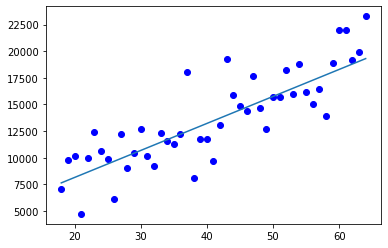

In [13]:
# From the linear regression, we got m=253.5 and b=3078.5. Here, we'll plot that
predicted_ys = get_y(m_age, b_age, ages_costs[:, 0])
plt.plot(ages_costs[:, 0], ages_costs[:, 1], 'bo', ages_costs[:, 0], predicted_ys)
plt.show()

## BMI Analysis

In [14]:
print(f'Average BMI: {bmis.mean()}')

Average BMI: 30.66339686098655


In [15]:
bmis_rounded = np.around(bmis)
bmis_unique, bmis_significant = get_unique_and_significant_values(bmis_rounded)
avg_cost_per_bmi = np.array([np.array(costs[bmis_rounded==i], dtype=float).mean() for i in bmis_significant])
bmis_costs = np.stack([bmis_significant, avg_cost_per_bmi], axis=-1)

In [16]:
m_bmi, b_bmi = run_linear_regressions(bmis_costs)
print(m_bmi, b_bmi, get_error(m_bmi, b_bmi, bmis_costs).mean())

441.00000000000244 22.98574027599991 1750.8574163459207


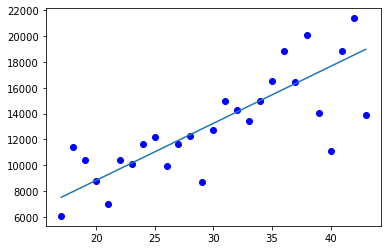

In [17]:
# Plot the results of the linear regression
predicted_ys = get_y(m_bmi, b_bmi, bmis_costs[:, 0])
plt.plot(bmis_costs[:, 0], bmis_costs[:, 1], 'bo', bmis_costs[:, 0], predicted_ys)
plt.show()

## Child Analysis

In [18]:
print(f'Average number of children: {children_nums.mean()}')

Average number of children: 1.0949177877429


In [19]:
children_unique, children_significant = get_unique_and_significant_values(children_nums)
avg_cost_per_children = np.array([np.array(costs[children_nums==i], dtype=float).mean() 
                                  for i in children_significant])
children_costs = np.stack([children_significant, avg_cost_per_children], axis=-1)

In [20]:
m_children, b_children = run_linear_regressions(children_costs)
print(m_children, b_children, get_error(m_children, b_children, children_costs).mean())

996.4832147683242 12365.861669798367 336.50741802591847


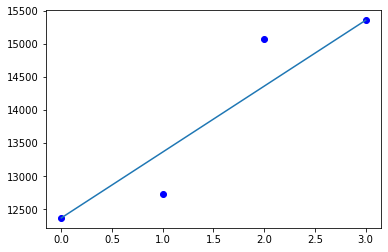

In [21]:
# Plot the results of the linear regression
predicted_ys = get_y(m_children, b_children, children_costs[:, 0])
plt.plot(children_costs[:, 0], children_costs[:, 1], 'bo', children_costs[:, 0], predicted_ys)
plt.show()

## Smoker Analysis

In [22]:
print(f'Percentage of smokers in dataset: {smokers.mean()*100:0.1f}%')

Percentage of smokers in dataset: 20.5%


In [23]:
smoker_unique, smoker_significant = get_unique_and_significant_values(smokers)
avg_cost_per_smoker = np.array([np.array(costs[smokers==i], dtype=float).mean() 
                                  for i in smoker_significant])
smoker_costs = np.stack([smoker_significant, avg_cost_per_smoker], axis=-1)

In [24]:
m_smoker = smoker_costs[1, 1] - smoker_costs[0, 1]
print(m_smoker)

23615.963533676637


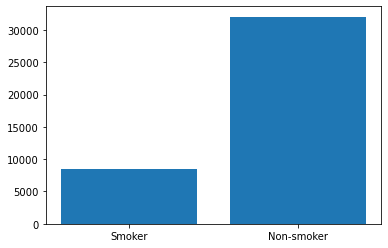

In [25]:
plt.bar(smoker_costs[:, 0], smoker_costs[:, 1], tick_label=['Smoker', 'Non-smoker'])
plt.show()

## Sex Analysis

In [26]:
print(f'Percentage of women in dataset: {sexes.mean()*100:0.1f}%')

Percentage of women in dataset: 49.5%


In [27]:
sex_unique, sex_significant = get_unique_and_significant_values(sexes)
avg_cost_per_sex = np.array([np.array(costs[sexes==i], dtype=float).mean() 
                                  for i in sex_significant])
sex_costs = np.stack([sex_significant, avg_cost_per_sex], axis=-1)

In [28]:
m_sex = sex_costs[1, 1] - sex_costs[0, 1]
print(m_sex)

-1387.1723338865468


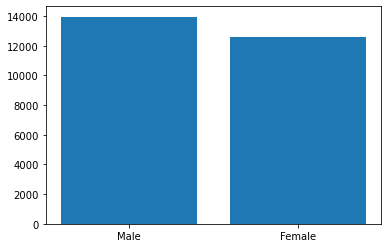

In [29]:
plt.bar(sex_costs[:, 0], sex_costs[:, 1], tick_label=['Male', 'Female'])
plt.show()

## Region Analysis

In [30]:
print(f'Percentage of each region in dataset:')
print(f'northwest: {(len(regions[regions==0])) / len(regions) * 100:0.1f}%')
print(f'northeast: {(len(regions[regions==1])) / len(regions) * 100:0.1f}%')
print(f'southeast: {(len(regions[regions==2])) / len(regions) * 100:0.1f}%')
print(f'southwest: {(len(regions[regions==3])) / len(regions) * 100:0.1f}%')

Percentage of each region in dataset:
northwest: 24.3%
northeast: 24.2%
southeast: 27.2%
southwest: 24.3%


In [31]:
region_unique, region_significant = get_unique_and_significant_values(regions)
avg_cost_per_region = np.array([np.array(costs[regions==i], dtype=float).mean() 
                                  for i in region_significant])
region_costs = np.stack([region_significant, avg_cost_per_region], axis=-1)

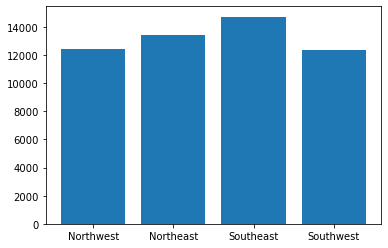

In [32]:
plt.bar(region_costs[:, 0], region_costs[:, 1], tick_label=['Northwest', 'Northeast', 'Southeast', 'Southwest'])
plt.show()

In [33]:
region_unique, region_significant = get_unique_and_significant_values(regions)
avg_bmi_per_region = np.array([np.array(bmis[regions==i], dtype=float).mean() 
                                  for i in region_significant])
region_bmis = np.stack([region_significant, avg_bmi_per_region], axis=-1)

In [34]:
region_bmis

array([[ 0.        , 29.19978462],
       [ 1.        , 29.17350309],
       [ 2.        , 33.35598901],
       [ 3.        , 30.59661538]])

The difference across regions can roughly be accounted to the difference between BMIs, so we'll ignore that for now.

In [35]:
m_region = 0.

In [36]:
regions_one_hot = (
    np.where(regions == 0, 1., 0.),
    np.where(regions == 1, 1., 0.),
    np.where(regions == 2, 1., 0.),
    np.where(regions == 3, 1., 0.),
)

## All Analysis
Since we have now calculated the analysis with each individual variable, we'll combine the relevent ms and find the mean error

In [37]:
print(m_age, m_bmi, m_children, m_smoker, m_sex, m_region)

253.46636682595246 441.00000000000244 996.4832147683242 23615.963533676637 -1387.1723338865468 0.0


In [38]:
variables_combined = np.stack([ages, bmis, children_nums, smokers, sexes, regions])
ms_all = np.stack([m_age, m_bmi, m_children, m_smoker, m_sex, m_region])
costs_calculated_no_bias = get_y(ms_all[:, None], 0., variables_combined).sum(axis=0)

To find the bias, we run the linear regression using all of the variables and calculated weights from before

In [39]:
ma, ba = run_linear_regressions(
    np.stack([costs_calculated_no_bias, costs], axis=-1), 
    initial_m=1., 
    initial_b=-15000.
)

In [40]:
ma, ba

(0.8230000000000105, -12060.48275388815)

In [41]:
get_error(ma, ba, np.stack([costs_calculated_no_bias, costs], axis=-1)).mean()

4365.013623158274

## Multiple Linear Regression

In [42]:
def get_loss(y_true, y_pred):
    return (y_pred - y_true) ** 2

In [43]:
def cost_derivative(y_true, y_pred):
    return 2 * (y_pred - y_true)

In [44]:
def weight_derivative(value):
    return value

In [45]:
def bias_derivative():
    return 1

In [46]:
def get_ys(values, weights, bias):
    return get_y(weights[:, None], 0, values).sum(axis=0) + bias

In [47]:
def get_gradient_vector(values, weights, bias, y_true, y_pred):
    dw = weight_derivative(values) * cost_derivative(y_true, y_pred)
    db = bias_derivative() * cost_derivative(y_true, y_pred)
    gradient_vector = np.concatenate([dw, [db]], axis=0)
    return gradient_vector.mean(axis=-1)

In [48]:
def run_multiple_regressions(inputs, costs, iterations=5000, learning_rate=1e-5, lr_decay=0.999995):
    # Initialize all ms to be the calculated values from before, with region=1000., b to be -15000
    weights = np.stack([m_age, m_bmi, m_children, m_smoker, m_sex, 1000., 1000., 1000., 1000.])
    bias = np.array([-15000.])
    weights_and_biases = np.concatenate([weights, bias])
    losses = []
    y_pred = get_ys(inputs, weights_and_biases[:-1], weights_and_biases[-1])
    for iteration in tqdm(range(iterations)):
        y_pred = get_ys(inputs, weights_and_biases[:-1], weights_and_biases[-1])
        loss = get_loss(costs, y_pred).mean()
        gv = get_gradient_vector(inputs, weights_and_biases[:-1], weights_and_biases[-1], costs, y_pred)
        weights_and_biases -= gv * learning_rate
        losses.append(loss)
        learning_rate *= lr_decay
    return losses, weights_and_biases

In [49]:
variables_combined = np.stack([ages, bmis, children_nums, smokers, sexes], axis=0)
variables_combined = np.concatenate([variables_combined, regions_one_hot], axis=0)
losses, wb = run_multiple_regressions(variables_combined, costs, iterations=1000000, learning_rate=1e-4)
print(wb)
yp = get_ys(variables_combined, wb[:-1], wb[-1])
print(np.abs(costs - yp).mean())
print(get_loss(costs, yp).mean())

  0%|          | 0/1000000 [00:00<?, ?it/s]

[   258.02007054    345.83690179    480.26734272  23865.60722408
    153.15522428   1457.84859367   1811.09870485    745.08071459
    839.80776852 -14146.16421837]
4178.702422546632
36504034.1911929


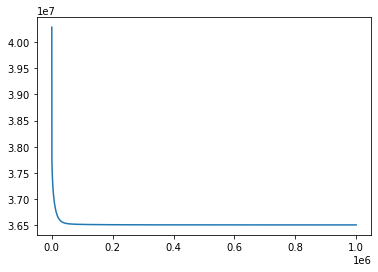

In [50]:
plt.plot(losses)
plt.show()

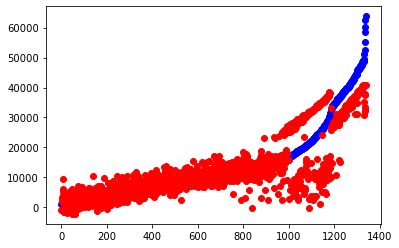

In [51]:
data = np.concatenate([variables_combined, [costs]], axis=0)
data_sorted = data[:, np.argsort(data, axis=-1)[-1]]
yp_sorted = get_ys(data_sorted[:-1], wb[:-1], wb[-1])
plt.plot(np.arange(len(costs)), data_sorted[-1], 'bo', np.arange(len(costs)), yp_sorted, 'ro')
plt.show()

In [52]:
print(f'Cost mean, std: {costs.mean()}, {costs.std()}')
mean = costs.mean()
std = costs.std()
lower, upper = mean - 2 * std, mean + 2 * std

Cost mean, std: 13270.422265141257, 12105.484975561612


In [53]:
valid_indices = np.where(np.logical_and(data[-1] < upper, data[-1] > lower))
print(np.array(valid_indices)[:10])
data_valid = data[:, np.array(valid_indices[-1])]

[[   0    1    2 ... 1335 1336 1337]]


In [54]:
losses_valid, wb_valid = run_multiple_regressions(data_valid[:-1], data_valid[-1], iterations=1000000, 
                                                  learning_rate=1e-4)
print(wb_valid)
yp_valid = get_ys(data_valid[:-1], wb_valid[:-1], wb_valid[-1])
print(np.abs(data_valid[-1] - yp_valid).mean())
print(get_loss(data_valid[-1], yp_valid).mean())
yp_valid.shape

  0%|          | 0/1000000 [00:00<?, ?it/s]

[   237.39326782    208.47117437    434.15513528  18139.00544197
    492.87594699   2483.90720873   2819.15101844   1558.57490528
   1840.78403975 -10297.5828278 ]
3141.3940388148785
26739299.953872744


(1230,)

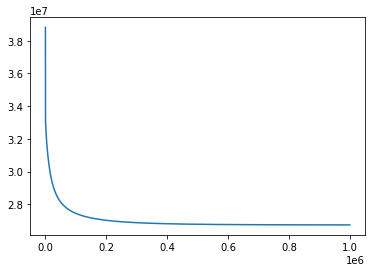

In [55]:
plt.plot(losses_valid)
plt.show()

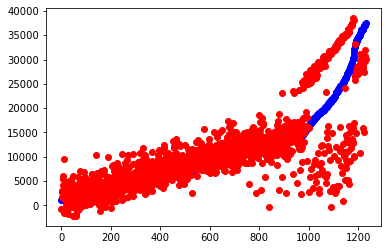

In [56]:
data_valid_sorted = data_valid[:, np.argsort(data_valid, axis=-1)[-1]]
yp_valid_sorted = get_ys(data_valid_sorted[:-1], wb[:-1], wb[-1])

plt.plot(np.arange(len(yp_valid)), data_valid_sorted[-1], 'bo', np.arange(len(yp_valid)), yp_valid_sorted, 'ro')
plt.show()